In [1]:
import gym
import numpy as np
import time
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras import Model

In [2]:
EPOCHS = 1000

env  =  gym.make('CartPole-v0')

games = []

for i in range(EPOCHS):
    observations = []
    obs = env.reset()
    observations.append(obs)
    for t in range(100):
        action = env.action_space.sample()
        obs, reward, done, _ = env.step(action)

        observations.append(obs)
        
        if done:
#             print(f'Episode {i} finished at time {t}')
            break
    games.append(np.stack(observations))

In [3]:
BATCH_SIZE = 32
BUFFER_SIZE = 1000
WINDOW_SIZE = BATCH_SIZE

def filter_max_length(x, max_length=WINDOW_SIZE):
    return tf.shape(x)[0] <= max_length

train_dataset = tf.data.Dataset.from_generator(lambda: games, output_types=tf.float32)
train_dataset = train_dataset.filter(filter_max_length)
train_dataset = train_dataset.cache()
# train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE, padded_shapes=(None,None))
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [4]:
iter(train_dataset.take(1)).next()

<tf.Tensor: shape=(32, 32, 4), dtype=float32, numpy=
array([[[-0.04515691, -0.01837284,  0.04578161,  0.03413424],
        [-0.04552436,  0.1760637 ,  0.0464643 , -0.2437599 ],
        [-0.04200309, -0.01969006,  0.0415891 ,  0.06320944],
        ...,
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ]],

       [[-0.04276861, -0.02536054, -0.03682623,  0.01933085],
        [-0.04327581, -0.21993555, -0.03643961,  0.30017102],
        [-0.04767453, -0.41451967, -0.03043619,  0.58114254],
        ...,
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ]],

       [[ 0.02133315, -0.02512128,  0.01652734, -0.04125911],
        [ 0.02083072,  0.16975982,  0.01570216, -0.32868204],
        [ 0.02422592, -0.02558211,  0.00912852, -

In [5]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable

In [6]:
class MultiHeadAttention(nn.Module):
    def __init__(self, heads, d_model, dropout = 0.1):
        super().__init__()
        
        self.d_model = d_model
        self.d_k = d_model // heads
        self.h = heads
        
        self.q_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)
        self.out = nn.Linear(d_model, d_model)
    
    def forward(self, q, k, v, mask=None):
        
        bs = q.size(0)
        
        # perform linear operation and split into h heads
        
        k = self.k_linear(k).view(bs, -1, self.h, self.d_k)
        q = self.q_linear(q).view(bs, -1, self.h, self.d_k)
        v = self.v_linear(v).view(bs, -1, self.h, self.d_k)
        
        # transpose to get dimensions bs * h * sl * d_model
       
        k = k.transpose(1,2)
        q = q.transpose(1,2)
        v = v.transpose(1,2)
# calculate attention using function we will define next
        scores = attention(q, k, v, self.d_k, mask, self.dropout)
        
        # concatenate heads and put through final linear layer
        concat = scores.transpose(1,2).contiguous()\
        .view(bs, -1, self.d_model)
        
        output = self.out(concat)
    
        return output

In [5]:
# Query*key gives the relevance measure - the better matched a key is to the query the higher it will activate and thus it will feature more in the v output
# V[Q*K]
def scaled_dot_product_attention(q, k, v, mask):
    """Calculate the attention weights.
    q, k, v must have matching leading dimensions.
    k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
    The mask has different shapes depending on its type(padding or look ahead) 
    but it must be broadcastable for addition.
    
    Args:
        q: query shape == (..., seq_len_q, depth)
        k: key shape == (..., seq_len_k, depth)
        v: value shape == (..., seq_len_v, depth_v)
        mask: Float tensor with shape broadcastable 
                    to (..., seq_len_q, seq_len_k). Defaults to None.
        
    Returns:
        output, attention_weights
    """

    matmul_qk = tf.matmul(q, k, transpose_b=True)    # (..., seq_len_q, seq_len_k)
    
    # scale matmul_qk
    dk = tf.cast(k.shape[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)    

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)    # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)    # (..., seq_len_q, depth_v)

    return output, attention_weights

In [6]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        assert d_model % self.num_heads == 0
        
        self.depth = d_model // self.num_heads
        
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        
        self.dense = tf.keras.layers.Dense(d_model)
                
    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
        
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]
        
        q = self.wq(q)    # (batch_size, seq_len, d_model)
        k = self.wk(k)    # (batch_size, seq_len, d_model)
        v = self.wv(v)    # (batch_size, seq_len, d_model)
        
        q = self.split_heads(q, batch_size)    # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)    # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)    # (batch_size, num_heads, seq_len_v, depth)
        
        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)
        
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])    # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))    # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)    # (batch_size, seq_len_q, d_model)
                
        return output, attention_weights

In [7]:
REPR_DIM = 32 # These are just for testing
SEQ_LEN = 10

temp_mha = MultiHeadAttention(d_model=REPR_DIM, num_heads=1)
y = tf.random.uniform((1, SEQ_LEN, REPR_DIM))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape

(TensorShape([1, 10, 32]), TensorShape([1, 1, 10, 10]))

In [8]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
        tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
    ])

In [9]:
# class DecoderLayer(tf.keras.layers.Layer):
#     def __init__(self, d_model, num_heads, dff, rate=0.1):
#         super(DecoderLayer, self).__init__()

#         self.mha1 = MultiHeadAttention(d_model, num_heads)
#         self.mha2 = MultiHeadAttention(d_model, num_heads)

#         self.ffn = point_wise_feed_forward_network(d_model, dff)

#         self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
#         self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
#         self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

#         self.dropout1 = tf.keras.layers.Dropout(rate)
#         self.dropout2 = tf.keras.layers.Dropout(rate)
#         self.dropout3 = tf.keras.layers.Dropout(rate)


#     def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
#         # enc_output.shape == (batch_size, input_seq_len, d_model)

#         # Decoder self-attention
#         attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
#         attn1 = self.dropout1(attn1, training=training)
#         out1 = self.layernorm1(attn1 + x)

#         # Encoder-Decoder attention (v,k,q)
#         attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
#         attn2 = self.dropout2(attn2, training=training)
#         out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

#         ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
#         ffn_output = self.dropout3(ffn_output, training=training)
#         out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

#         return out3, attn_weights_block1, attn_weights_block2

In [10]:
# Variant of the decoder for decoder-only architectures like GPT-2 where we forgo an encoder
class DecoderOnlyLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderOnlyLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)


    def call(self, x, training, look_ahead_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)

        # Decoder masked self-attention
        attn, attn_weights_block = self.mha(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn = self.dropout1(attn, training=training)
        out = self.layernorm1(attn + x)

        ffn_output = self.ffn(out)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out_final = self.layernorm2(ffn_output + out)  # (batch_size, target_seq_len, d_model)

        return out_final, attn_weights_block

In [11]:
sample_decoder_layer = DecoderOnlyLayer(REPR_DIM, 1, REPR_DIM*4)

sample_decoder_layer_output, _ = sample_decoder_layer(tf.random.uniform((64, SEQ_LEN, REPR_DIM)), False, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

TensorShape([64, 10, 32])

### Positional Embeddings
$P E_{(p o s, 2 i)}=\sin \left(p o s / 10000^{2 i / d_{m o d e l}}\right)$

$P E_{(p o s, 2 i+1)}=\cos \left(p o s / 10000^{2 i / d_{m o d e l}}\right)$

In [12]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

In [13]:
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

In [14]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

In [15]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

    # add extra dimensions to add the padding
    # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [16]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderOnlyLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
    
    def call(self, x, training, look_ahead_mask):

        seq_len = tf.shape(x)[1]
        attention_weights = {}

#         x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :] # would concat be better?

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1 = self.dec_layers[i](x, training, look_ahead_mask)
      
            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
    
        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights

In [17]:
sample_decoder = Decoder(num_layers=1, d_model=REPR_DIM, num_heads=1, 
                         dff=REPR_DIM*4, maximum_position_encoding=5000)
temp_input = tf.random.uniform((64, SEQ_LEN, REPR_DIM), dtype=tf.float32, minval=0, maxval=200)

output, attn = sample_decoder(temp_input, 
                              training=False,
                              look_ahead_mask=None)

output.shape, attn['decoder_layer1_block1'].shape

(TensorShape([64, 10, 32]), TensorShape([64, 1, 10, 10]))

## Transformer

In [18]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, pe_target, rate=0.1):
        super(Transformer, self).__init__()

        self.decoder = Decoder(num_layers, d_model, num_heads, dff, pe_target, rate)

    def call(self, tar, training, look_ahead_mask):

        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output, attention_weights = self.decoder(tar, training, look_ahead_mask)

        return dec_output, attention_weights

In [19]:
sample_transformer = Transformer(
    num_layers=1, d_model=REPR_DIM, num_heads=1, dff=REPR_DIM*4, pe_target=6000)

temp_input = tf.random.uniform((64, SEQ_LEN, REPR_DIM), dtype=tf.float32, minval=0, maxval=200)

fn_out, _ = sample_transformer(temp_input, training=False, look_ahead_mask=None)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([64, 10, 32])

In [20]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

In [21]:
loss_object = tf.keras.losses.MeanSquaredError(reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask[:,:,0]

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

In [22]:
def create_masks(tar):
    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by 
    # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar[:,:,0]) # drop the state dim
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return combined_mask

In [23]:
# checkpoint_path = "./checkpoints/train"

# ckpt = tf.train.Checkpoint(transformer=transformer,
#                            optimizer=optimizer)

# ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# # if a checkpoint exists, restore the latest checkpoint.
# if ckpt_manager.latest_checkpoint:
#     ckpt.restore(ckpt_manager.latest_checkpoint)
#     print ('Latest checkpoint restored!!')

In [24]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None, None), dtype=tf.float32),
]

# @tf.function(input_signature=train_step_signature)
def train_step(tar):
    tar_inp = tar[:, :-1] # batch, time, dim
    tar_real = tar[:, 1:]

    combined_mask = create_masks(tar_inp)

    with tf.GradientTape() as tape:
        predictions, _ = transformer(tar_inp, 
                                     True, 
                                     combined_mask)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)
#     train_accuracy(tar_real, predictions)

In [25]:
OBS_DIM = 4
transformer = Transformer(num_layers=1, d_model=OBS_DIM, num_heads=1, dff=OBS_DIM*4, pe_target=100)

In [26]:
EPOCHS = 100

for epoch in range(EPOCHS):
    start = time.time()

    train_loss.reset_states()
#     train_accuracy.reset_states()

    for (batch, tar) in enumerate(train_dataset):
        train_step(tar)

    if batch % 50 == 0:
        print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
            epoch + 1, batch, train_loss.result(), train_accuracy.result()))

#     if (epoch + 1) % 5 == 0:
#         ckpt_save_path = ckpt_manager.save()
#     print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
#                                                          ckpt_save_path))

    print ('Epoch {} Loss {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
#                                                 train_accuracy.result()
                                                        )
          )

    print ('Time taken for 1 epoch: {:.4f} secs\n'.format(time.time() - start))

Epoch 1 Loss 0.1946
Time taken for 1 epoch: 0.7883 secs

Epoch 2 Loss 0.1910
Time taken for 1 epoch: 0.6994 secs

Epoch 3 Loss 0.1871
Time taken for 1 epoch: 0.7115 secs

Epoch 4 Loss 0.1839
Time taken for 1 epoch: 0.6985 secs

Epoch 5 Loss 0.1803
Time taken for 1 epoch: 0.6986 secs

Epoch 6 Loss 0.1761
Time taken for 1 epoch: 0.6796 secs

Epoch 7 Loss 0.1730
Time taken for 1 epoch: 0.6829 secs

Epoch 8 Loss 0.1703
Time taken for 1 epoch: 0.6893 secs

Epoch 9 Loss 0.1671
Time taken for 1 epoch: 0.6894 secs

Epoch 10 Loss 0.1632
Time taken for 1 epoch: 0.6876 secs

Epoch 11 Loss 0.1616
Time taken for 1 epoch: 0.7085 secs

Epoch 12 Loss 0.1590
Time taken for 1 epoch: 0.6941 secs

Epoch 13 Loss 0.1551
Time taken for 1 epoch: 0.6938 secs

Epoch 14 Loss 0.1527
Time taken for 1 epoch: 0.6846 secs

Epoch 15 Loss 0.1506
Time taken for 1 epoch: 0.6866 secs

Epoch 16 Loss 0.1469
Time taken for 1 epoch: 0.7033 secs

Epoch 17 Loss 0.1457
Time taken for 1 epoch: 0.6950 secs

Epoch 18 Loss 0.1441
Ti

In [120]:
# Todo: Need to incorporate gym env 'done' as end token
# This eval takes in t=0 state and keeps generating new states, feeding it's predicted output back in at every step
# This is essentially GPT2 unconditional autoregressive generation operating in open loop mode - rather than closed loop teacher forcin

def evaluate(inp_sequence):
    output = tf.expand_dims(tf.expand_dims(inp_sequence[0],0),1) # seed input at t=0, now we generate the rest
#     import pdb
#     pdb.set_trace()

    for i in range(WINDOW_SIZE):
        look_ahead_mask = create_masks(output)

        # predictions.shape == (batch_size, seq_len, vocab_size)
        predictions, attention_weights = transformer(output, 
                                                     False,
                                                     look_ahead_mask)

        # select the last word from the seq_len dimension
        predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

#         predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # return the result if the predicted_id is equal to the end token
        if tf.reduce_sum(tf.cast(predictions, tf.float32))==0:
            return tf.squeeze(output,0), attention_weights 

        # concatentate the predicted_id to the output which is given to the decoder
        # as its input.
        output = tf.concat([output, predictions], axis=1)

    return tf.squeeze(output,0), attention_weights

In [121]:
# This plots the attention weights which signify how the output timesteps attend to the input timesteps
# For data that is linearly correlated in time we expect a diagonal matrix
def plot_attention_weights(attention, sequence, result, layer):
    fig = plt.figure(figsize=(16, 8))

#     sentence = tokenizer_pt.encode(sentence)

    attention = tf.squeeze(attention[layer], axis=0) # layer, head, time, time

    for head in range(attention.shape[0]):
        ax = fig.add_subplot(2, 4, head+1)

        # plot the attention weights
        ax.matshow(attention[head][:-1, :], cmap='viridis')

        fontdict = {'fontsize': 10}

#         ax.set_xticks(range(len(sequence)+2))
#         ax.set_yticks(range(len(result)))

#         ax.set_ylim(len(result)-1.5, -0.5)

#         ax.set_xticklabels(
#             ['<start>']+[tokenizer_pt.decode([i]) for i in sentence]+['<end>'], 
#             fontdict=fontdict, rotation=90)

#         ax.set_yticklabels([tokenizer_en.decode([i]) for i in result 
#                             if i < tokenizer_en.vocab_size], 
#                            fontdict=fontdict)

        ax.set_xlabel('Head {}'.format(head+1))

    plt.tight_layout()
    plt.show()

In [122]:
def predict_state(sequence, plot=''):
    predicted_sequence, attention_weights = evaluate(sequence)

    print('Input: {}'.format(sequence))
    print('Predicted translation: {}'.format(predicted_sequence))
    
    if plot:
        plot_attention_weights(attention_weights, sequence, predicted_sequence, plot)

In [123]:
example_trajectory = iter(train_dataset.take(1)).next()[0]
example_trajectory.shape

TensorShape([32, 4])

Input: [[-0.04515691 -0.01837284  0.04578161  0.03413424]
 [-0.04552436  0.1760637   0.0464643  -0.2437599 ]
 [-0.04200309 -0.01969006  0.0415891   0.06320944]
 [-0.04239689 -0.21538286  0.04285329  0.36871848]
 [-0.04670455 -0.41108668  0.05022766  0.6745997 ]
 [-0.05492628 -0.60686934  0.06371965  0.9826641 ]
 [-0.06706367 -0.80278456  0.08337294  1.2946614 ]
 [-0.08311936 -0.608815    0.10926616  1.0292009 ]
 [-0.09529566 -0.41530332  0.12985018  0.77272487]
 [-0.10360172 -0.22218426  0.14530468  0.5235537 ]
 [-0.10804541 -0.4190202   0.15577576  0.85826564]
 [-0.11642581 -0.61588204  0.17294106  1.1955959 ]
 [-0.12874345 -0.42336828  0.19685298  0.96172446]
 [-0.13721082 -0.6205127   0.21608748  1.3092316 ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.       

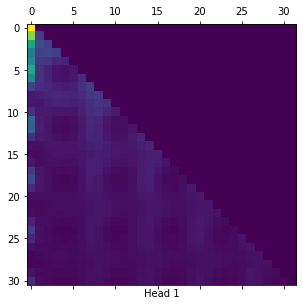

In [124]:
predict_state(example_trajectory, plot='decoder_layer1_block1');